## Comparaison de flux d'eau douce en absolu

Dans ce script : 
 - Intégration du flux d'eau douce sur l'océan austral
 - (Intégration du flux sur le temps pour obtenir une quantité totale d'eau douce éventuellement)

In [1]:
## Importation des modules et packages python nécessaires

import numpy as np
import xarray as xr
import os
from netCDF4 import Dataset
import matplotlib
import colormap as cmaps
import matplotlib.cm as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import dask

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

/home/albert/anaconda2/lib/python2.7/site-packages/matplotlib/ticker.py:1685: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


In [2]:
## Fichiers de fux de fonte + grille
new_file="/media/extra/DATA/ESOUTH12/ESOUTH12.L75-MJMgd16_y1990-2015_1m_bergmelt.nc"
grid_file="/media/extra/DATA/ESOUTH12/ESOUTH12.L75-MJMgd16_mask.nc"
former_file = "/media/extra/DATA/ESOUTH12/mmc2.nc"
cell_size_file = "/media/extra/DATA/ESOUTH12/ESOUTH12.L75-MJMgd16_mesh_hgr.nc"

!ls $new_file
!ls $grid_file
!ls $former_file
!ls $cell_size_file

# Ouverture des fichiers avec xarray
dsmelt_new=xr.open_dataset(new_file, chunks={'time_counter':1}) # chunk = on l'ouvre par morceaux de temps pour accélérer l'exécution du script.
#dsmelt=xr.open_dataset(berg_file, chunks={'x':1000, 'y':400}) on peut aussi l'ouvrir par morceau de grille, voir lequel est le plus efficace.
dsg=xr.open_dataset(grid_file)
dsmelt_former = xr.open_dataset(former_file)
cell_size_var = xr.open_dataset(cell_size_file)

/media/extra/DATA/ESOUTH12/ESOUTH12.L75-MJMgd16_y1990-2015_1m_bergmelt.nc
/media/extra/DATA/ESOUTH12/ESOUTH12.L75-MJMgd16_mask.nc
/media/extra/DATA/ESOUTH12/mmc2.nc
/media/extra/DATA/ESOUTH12/ESOUTH12.L75-MJMgd16_mesh_hgr.nc


# BLOC LONG A FAIRE TOURNER !

In [3]:
# Réalisation d'une climatologie pour le nouveau projet (l'ancien est déjà donné sour cette forme)
climatology =dsmelt_new.groupby('time_counter.month').mean('time_counter')
clim=climatology.berg_melt
clim_new = clim.values

/home/albert/anaconda2/lib/python2.7/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:
/home/albert/anaconda2/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [4]:
# Ancien projet variable pour la climatologie
clim_former = dsmelt_former.Icb_flux

In [5]:
# chargement des coordonnées pour les deux projets

lon_new = dsg.nav_lon
lat_new = dsg.nav_lat
lon_former = dsmelt_former.longitude
lat_former = dsmelt_former.latitude

In [6]:
lon_former.shape

(400, 1442)

In [7]:
from mpl_toolkits.basemap import pyproj
ee = pyproj.Geod(ellps='GRS80') #c'est pour la avoir le rayon de la terre précisément

az12,az21,dist = ee.inv(lon_former[0,0],lat_former[0,0],lon_former[0,1],lat_former[0,0])

print dist

6275.37220051


In [14]:
az12,az21,dist = ee.inv(lon_former[399,0],lat_former[399,0],lon_former[398,0],lat_former[398,0])

print dist

25270.6920653


In [83]:
# Taille d'une cellule

mask_value = dsg.fmaskutil[0,:,:]
longitude_size = cell_size_var.e1t
latitude_size = cell_size_var.e2t
cell_surface = longitude_size*latitude_size
cell_surface = cell_surface[0,:,:]*mask_value
total_surface = np.nansum(cell_surface, axis = 1)

array([  0.00000000e+00,   0.00000000e+00,   3.48126437e+06, ...,
         2.20732990e+11,   2.20721056e+11,   2.20586856e+11])

### Climatologie annuelle

In [80]:
clim_year_former = np.mean(clim_former, axis = 0)
clim_year_new = np.mean(clim_new, axis = 0)

Pour le flux moyen zonal, on pondère la moyenne par la surface de la cellule.

In [88]:
zonal_mean_new = (np.nanmean(clim_year_new*cell_surface, axis = 1))/total_surface
zonal_mean_new_non_pondere = np.nanmean(clim_year_new, axis = 1)
zonal_mean_former = np.nanmean(clim_year_former, axis = 1)

/home/claudine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/claudine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/claudine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


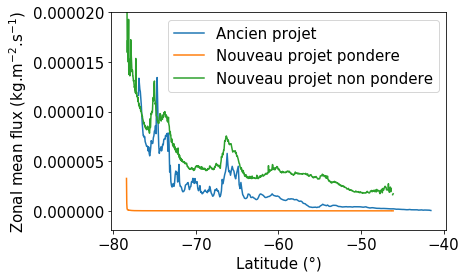

In [89]:
plt.figure()
matplotlib.rcParams.update({'font.size':15})
plt.plot(lat_former[:,0], zonal_mean_former, label='Ancien projet')
plt.plot(lat_new[:,0], zonal_mean_new, label='Nouveau projet pondere')
plt.plot(lat_new[:,0], zonal_mean_new_non_pondere, label='Nouveau projet non pondere')
plt.xlabel('Latitude (°)')
plt.ylabel('Zonal mean flux (kg.m$^{-2}$.s$^{-1}$)')
plt.legend()
plt.ylim(ymax = 0.00002)
plt.show()

### Climatologie mensuelle

/home/claudine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/claudine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


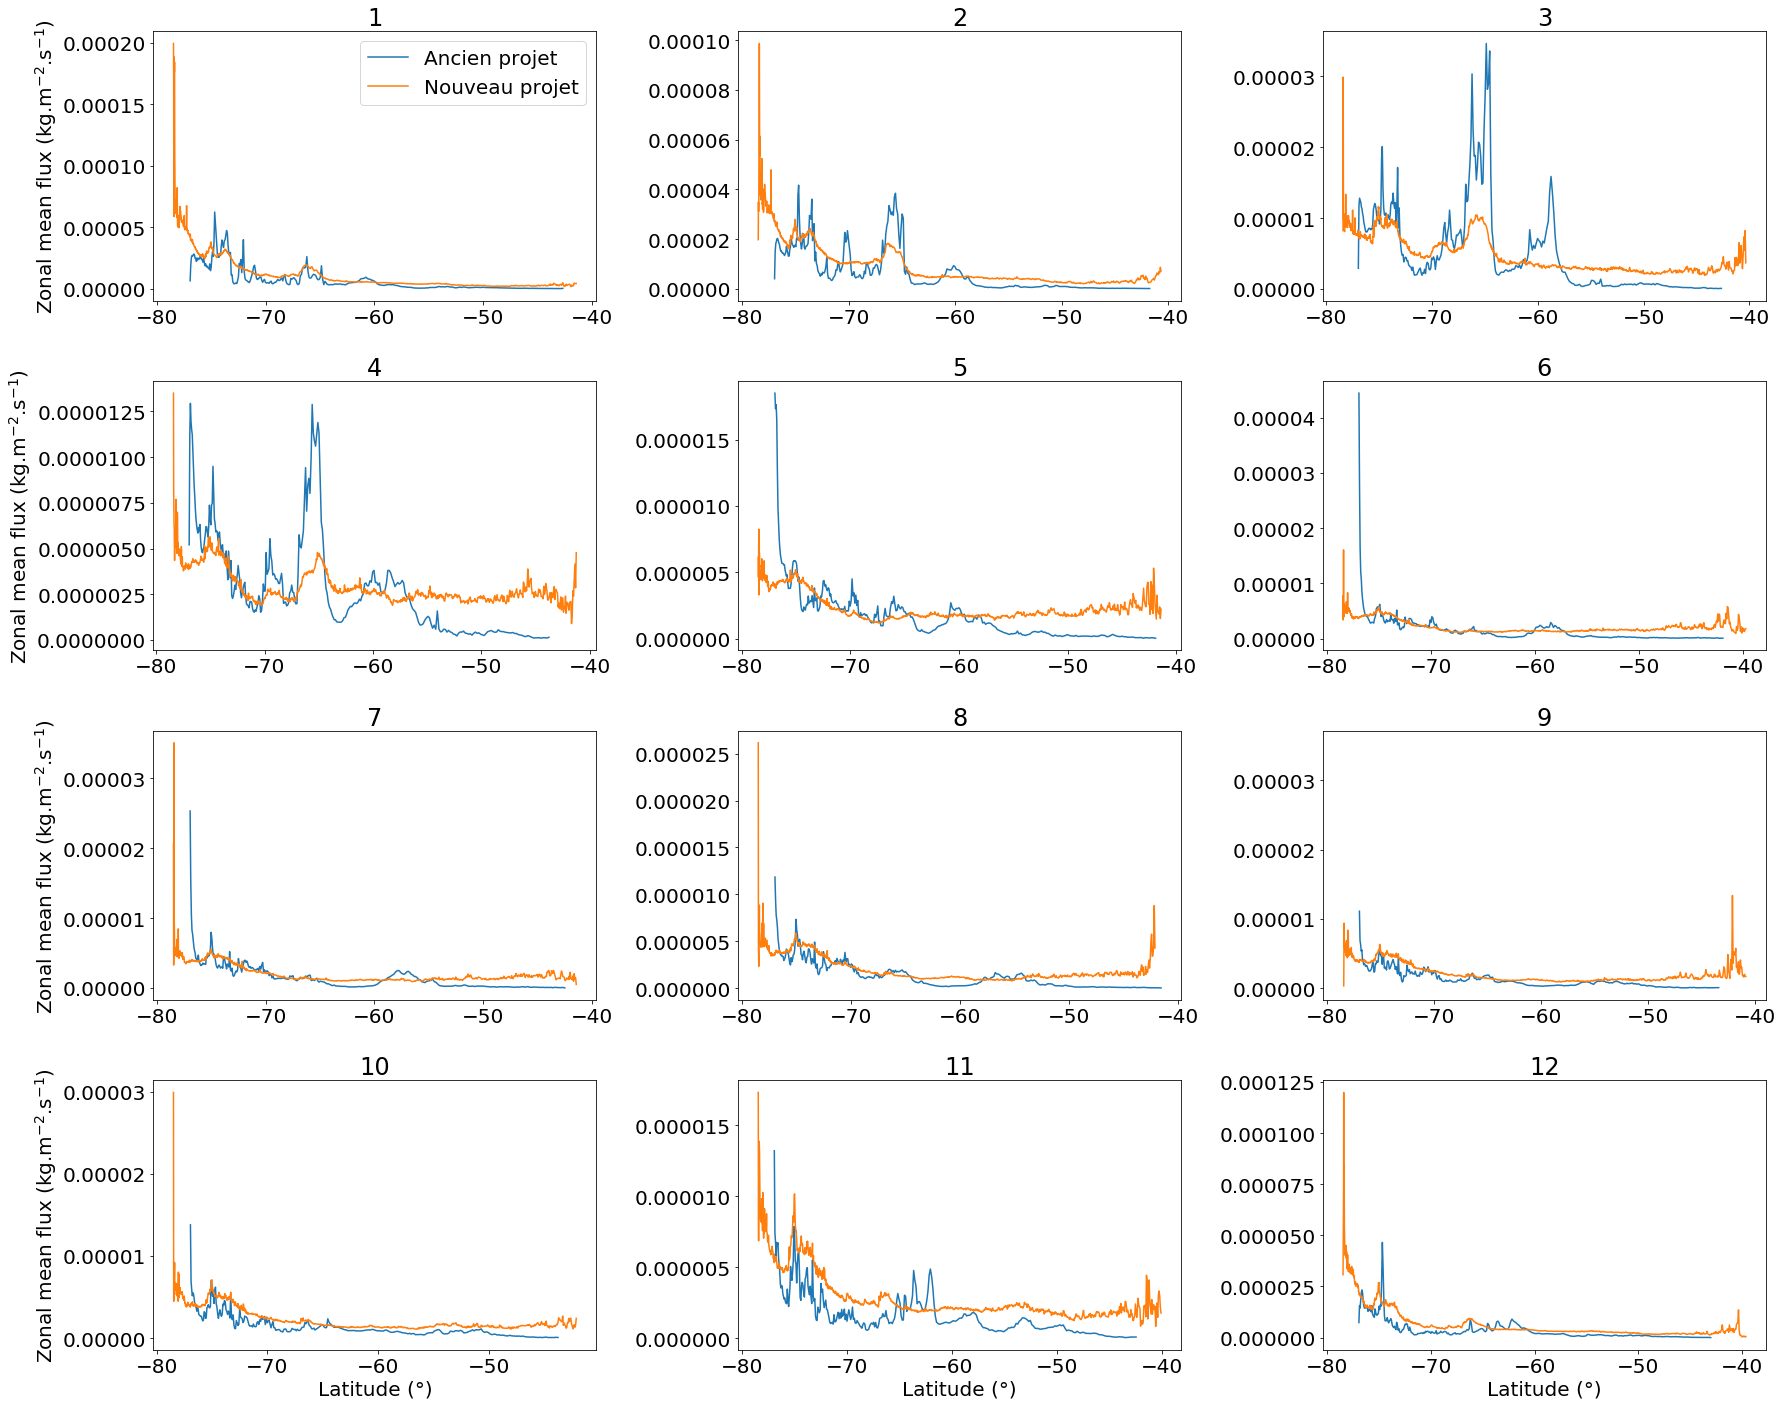

In [99]:
zonal_mean_former_month = np.nanmean(clim_former, axis = 2)
zonal_mean_new_month = np.nanmean(clim_new, axis = 2)
fig =plt.figure(figsize=(25,20))

matplotlib.rcParams.update({'font.size':20})
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(lat_former[:,0], zonal_mean_former_month[i], label='Ancien projet')
    plt.plot(lat_new[:,0], zonal_mean_new_month[i], label='Nouveau projet')
    plt.title(i+1)
    if i == 0 :
        plt.legend()
    if i == 9 or i == 10 or i ==11:
        plt.xlabel('Latitude (°)')
    if i == 0 or i == 3 or i == 6 or i == 9 :
        plt.ylabel('Zonal mean flux (kg.m$^{-2}$.s$^{-1}$)')
fig.tight_layout()
plt.show()